# Sberbank Housing - Baseline Model
## Minimal Preprocessing Approach

Data source: https://www.kaggle.com/competitions/sberbank-russian-housing-market/data

## Imports

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data
house_data = pd.read_csv(r"data/sberbank_housing.csv", index_col=0, low_memory=False)

print(f"Original dataset shape: {house_data.shape}")
print(f"Missing values per column:\n{house_data.isnull().sum()}")

Original dataset shape: (27000, 20)
Missing values per column:
id                     0
timestamp              0
price_doc              0
full_sq                0
life_sq             5537
kitch_sq            9572
floor                167
max_floor           9572
build_year         12869
num_room            9572
state              13067
product_type           0
ecology                0
sub_area               0
raion_popul            0
kindergarten_km        0
school_km              0
park_km                0
railroad_km            0
metro_min_walk        14
dtype: int64


## Load Data & Initial Exploration

In [26]:
# Clean column names
house_data.columns = [c.lower().strip().replace(" ", "_") for c in house_data.columns]

# Drop non-predictive columns
house_data = house_data.drop(columns=["timestamp", "id"])

In [27]:
# Display basic dataset information
print(f"Original dataset shape: {house_data.shape}")
print("Dataset contains {0} rows and {1} columns".format(house_data.shape[0], house_data.shape[1]))

Original dataset shape: (27000, 18)
Dataset contains 27000 rows and 18 columns


In [28]:
# Identify categorical columns
categorical_cols = house_data.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorical columns: {len(categorical_cols)}")
print("="*60)

# Initialize lists for cardinality-based categorization
low_card = []
high_card = []
cardinality_threshold = 10

for col in categorical_cols:
    n_unique = house_data[col].nunique()
    n_missing = house_data[col].isna().sum()
    missing_pct = (n_missing / len(house_data)) * 100
    
    # Categorize based on cardinality
    if n_unique < cardinality_threshold:
        low_card.append(col)
        cardinality_label = "LOW"
    else:
        high_card.append(col)
        cardinality_label = "HIGH"
    
    print(f"\n{col}: [{cardinality_label} cardinality]")
    print(f"  Unique values: {n_unique}")
    print(f"  Missing: {n_missing} ({missing_pct:.1f}%)")
    print(f"  Top 5 values:")
    print(house_data[col].value_counts().head(5).to_string().replace('\n', '\n    '))

print("\n" + "="*60)
print("\nEncoding Strategy:")
print(f"  LOW cardinality (<{cardinality_threshold} unique)  → One-Hot Encoding: {low_card}")
print(f"  HIGH cardinality (≥{cardinality_threshold} unique) → Drop for baseline: {high_card}")
print("="*60)


Categorical columns: 3

product_type: [LOW cardinality]
  Unique values: 2
  Missing: 0 (0.0%)
  Top 5 values:
product_type
    Investment       17542
    OwnerOccupier     9458

ecology: [LOW cardinality]
  Unique values: 5
  Missing: 0 (0.0%)
  Top 5 values:
ecology
    poor            7215
    no data         6570
    good            6548
    excellent       3419
    satisfactory    3248

sub_area: [HIGH cardinality]
  Unique values: 146
  Missing: 0 (0.0%)
  Top 5 values:
sub_area
    Nekrasovka                 1540
    Poselenie Sosenskoe        1522
    Poselenie Vnukovskoe       1048
    Poselenie Moskovskij        807
    Poselenie Voskresenskoe     693


Encoding Strategy:
  LOW cardinality (<10 unique)  → One-Hot Encoding: ['product_type', 'ecology']
  HIGH cardinality (≥10 unique) → Drop for baseline: ['sub_area']


## Categorical Features Overview

Examine categorical columns to determine encoding strategy based on cardinality.

## Target Distribution Analysis

**Why check target distribution?**

1. **Normality Assumption**: Linear regression assumes residuals follow a bell-shaped curve distribution
2. **Homoscedasticity**: Residuals should be scattered randomly with no patterns

Target distribution is one of the biggest factors affecting both assumptions.

**Goal**: Homoscedastic + Normal residuals (IDEAL)

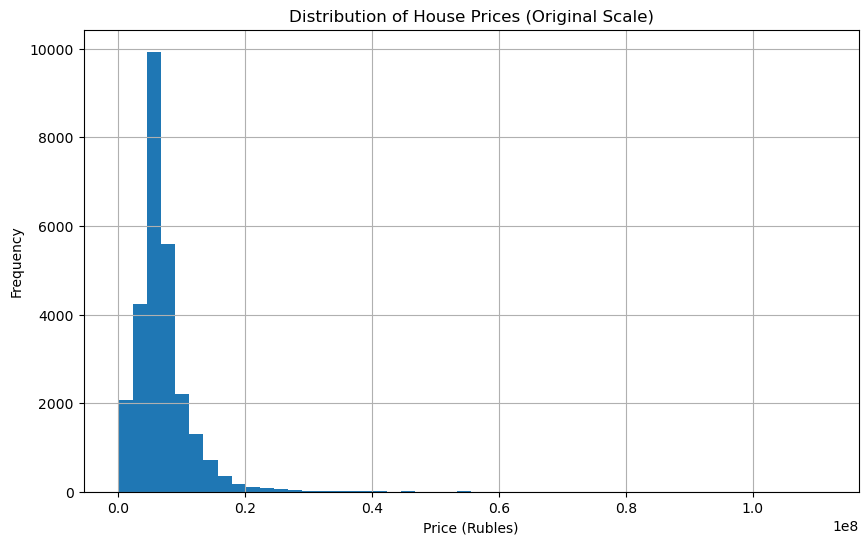

In [29]:
# Visualize the distribution of our target variable (house prices)
house_data["price_doc"].hist(bins=50, figsize=(10, 6))
plt.title("Distribution of House Prices (Original Scale)")
plt.xlabel("Price (Rubles)")
plt.ylabel("Frequency")
plt.show()

In [30]:
# Let's apply log transfrom to the target variable to reduce skewness
house_data["price_doc"] = np.log1p(house_data["price_doc"])

## Train-Test Split

Split strategy: 80% training, 20% testing

In [31]:
X = house_data.drop("price_doc", axis=1)
y = house_data["price_doc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (21600, 17)
Test set: (5400, 17)


## Apply Categorical Encoding

In [32]:
# One-hot encode low cardinality columns (using lists from earlier)
# Note: pd.get_dummies creates integer (0/1) columns by default, not boolean
X_train_encoded = pd.get_dummies(X_train, columns=low_card, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=low_card, drop_first=True, dtype=int)

# Align columns (in case test set has different categories)
X_train, X_test = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"One-hot encoded {len([c for c in low_card if c in X.columns])} low-cardinality features: {[c for c in low_card if c in X.columns]}")

# Drop high cardinality columns for baseline
high_card_in_data = [c for c in high_card if c in X_train.columns]
if high_card_in_data:
    X_train = X_train.drop(columns=high_card_in_data)
    X_test = X_test.drop(columns=high_card_in_data)
    print(f"Dropped {len(high_card_in_data)} high-cardinality features: {high_card_in_data}")

print(f"\nFinal shape after encoding:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")

One-hot encoded 2 low-cardinality features: ['product_type', 'ecology']
Dropped 1 high-cardinality features: ['sub_area']

Final shape after encoding:
  Training set: (21600, 19)
  Test set: (5400, 19)


## Baseline Model with Categorical Encoding

Uses complete numeric columns plus one-hot encoded low cardinality categorical features.

In [33]:
# Use all numeric columns (including encoded categoricals) with simple median imputation
from sklearn.impute import SimpleImputer

# Get all numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Simple median imputation for missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train[numeric_cols])
X_test_imputed = imputer.transform(X_test[numeric_cols])

# Train baseline model
baseline_model = Ridge(random_state=42)
baseline_model.fit(X_train_imputed, y_train)

# Predictions
baseline_pred = baseline_model.predict(X_test_imputed)

print(f"Features used: {len(numeric_cols)} (numeric + encoded categorical)")

Features used: 19 (numeric + encoded categorical)


In [34]:
# Calculate metrics on log scale
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Convert back to dollar scale for interpretation
baseline_pred_dollars = np.expm1(baseline_pred)
y_test_dollars = np.expm1(y_test)
baseline_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars))

residuals = y_test - baseline_pred

In [41]:
print(f"   RMSE: {baseline_rmse:.3f} (log scale)")

baseline_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars))
print(f"   RMSE: {baseline_rmse_dollars:.3f} (rubles scale)")

   RMSE: 0.528 (log scale)
   RMSE: 5789060.940 (rubles scale)


## Residual Diagnostics

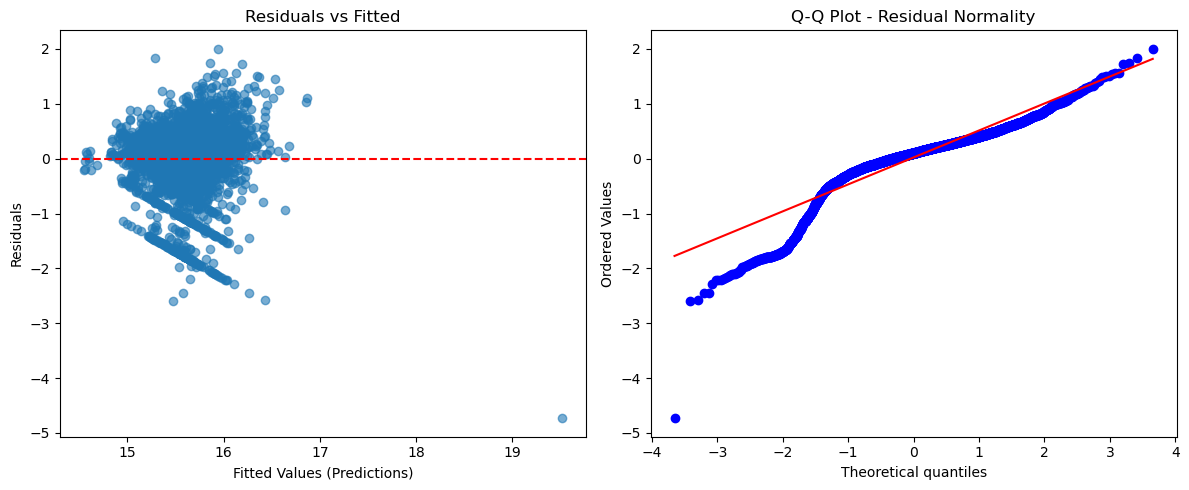

In [36]:
# Calculate residuals
residuals = y_test - baseline_pred

# 1. Check homoscedasticity
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(baseline_pred, residuals, alpha=0.6)
plt.xlabel("Fitted Values (Predictions)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(y=0, color='red', linestyle='--')

# 2. Check normality of residuals
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot - Residual Normality")

plt.tight_layout()
plt.show()

## Diagnostic Results

Both plots show acceptable patterns with minor deviations rather than major violations.

**Left Plot - Homoscedasticity: Good**
- Random cloud of points around y=0
- No obvious funnel/fan pattern
- No strong curved patterns
- Variance looks reasonably constant across prediction range

**Right Plot - Normality: Mostly Good with Some Issues**
- Middle section: Points follow the diagonal line well
- Tails: Some deviation, especially in lower tail
- Overall: Reasonably normal but slightly heavy-tailed

## Save Baseline for Comparison

In [37]:
# save our baseline model's rmse to compare later
baseline_rmse_dollars = str(np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars)))
with open("baseline_rmse.txt","w") as f:
    f.write(baseline_rmse_dollars)
    f.flush()